# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, Normalizer

from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import json
import warnings
import os
import ast

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [4]:
# config_url = '../../hourlyAPI/config/coins/coins_to_track.json'
# f = open(config_url)
# tracked_coins = ast.literal_eval(json.load(f)['coins'])
# f.close()
tracked_coins = ["XEM","ZRX",
        "BTC","ETH","BNB","XRP","LTC","BCH","XLM","EOS",
        "LRC","MKR","BAT","ZIL",
        "RLC",
        "ATOM","ANT","ADA","CRO","XTZ","TRX","LINK","FTM",
        "ENJ","DOGE","MANA",
        "STMX","STORJ"]
print(tracked_coins)


['XEM', 'ZRX', 'BTC', 'ETH', 'BNB', 'XRP', 'LTC', 'BCH', 'XLM', 'EOS', 'LRC', 'MKR', 'BAT', 'ZIL', 'RLC', 'ATOM', 'ANT', 'ADA', 'CRO', 'XTZ', 'TRX', 'LINK', 'FTM', 'ENJ', 'DOGE', 'MANA', 'STMX', 'STORJ']


In [5]:
def load_coin_dataset(coin):
    url = '../../../data/coins_tracked/' + coin
    years = ['2019', '2020', '2021', '2022']
    df = pd.DataFrame()
    start_train = "2019-07-01 01:00:00"

    if os.path.exists(url):
        for y in years:
            path = url + '/'+ y +'.csv'
            if os.path.exists(path):
                df_year = pd.read_csv(path)
                df_year.Time = pd.to_datetime(df_year.Time)
                df_year.set_index("Time", inplace = True)
                df_year[coin] = df_year.Price
                df_year.drop(['Price', 'BidVolume', 'AskVolume'], axis=1, inplace = True)
                df = pd.concat([df, df_year])
                
            else:
                print('For coin ', coin, ' year ', y, ' is not present')
    else:
        print('Data not available for ', coin)
    
    df.sort_index(inplace=True)
    df = df[start_train: df.index[-1]]

    return df

In [7]:
df = pd.DataFrame()
for coin in tracked_coins:
    df_coin = load_coin_dataset(coin)
    df = df.join(df_coin, how="outer")
df.head()

,XEM,ZRX,BTC,ETH,BNB,XRP,LTC,BCH,XLM,EOS,...,CRO,XTZ,TRX,LINK,FTM,ENJ,DOGE,MANA,STMX,STORJ
Time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 01:00:00,0.09117,0.3001,10898.54,294.04,32.02,0.4134,123.81,408.04,0.1074,5.890,...,0.06387,0.9453,0.03275,3.490,0.02711,0.1231,0.003254,0.05071,0.002763,0.2624
2019-07-01 02:00:00,0.09170,0.3034,10999.70,296.99,32.33,0.4111,124.96,413.37,0.1080,5.941,...,0.06556,0.9513,0.03312,3.481,0.02751,0.1239,0.003275,0.04994,0.002851,0.2607
2019-07-01 03:00:00,0.09177,0.3054,11085.91,298.21,32.75,0.4105,125.05,415.50,0.1085,5.923,...,0.06519,0.9493,0.03307,3.506,0.02704,0.1272,0.003278,0.05379,0.002938,0.2605
2019-07-01 04:00:00,0.09386,0.3041,11086.59,298.45,32.57,0.4122,125.06,417.63,0.1087,5.927,...,0.06353,0.9471,0.03302,3.507,0.02757,0.1273,0.003300,0.04949,0.002838,0.2618
2019-07-01 05:00:00,0.09243,0.3026,11013.00,295.04,32.32,0.4076,122.46,409.35,0.1080,5.868,...,0.06332,0.9375,0.03268,3.487,0.02739,0.1257,0.003274,0.04945,0.002802,0.2610


In [33]:
df_test = pd.DataFrame(index=df.index)
df_test['ETH'] = df['ETH']
df_test['log_diff'] = np.log(df_test['ETH']).diff(1)
df_test['prev_log_diff'] = df_test['log_diff'].shift(1)
df_test['next_log_diff'] = df_test['log_diff'].shift(-1)
df_test.dropna(inplace=True)
df_test.head()

,ETH,log_diff,prev_log_diff,next_log_diff
Time,,,,
2019-07-01 03:00:00,298.21,0.004099,0.009983,0.000804
2019-07-01 04:00:00,298.45,0.000804,0.004099,-0.011491
2019-07-01 05:00:00,295.04,-0.011491,0.000804,-0.005472
2019-07-01 06:00:00,293.43,-0.005472,-0.011491,0.000273
2019-07-01 07:00:00,293.51,0.000273,-0.005472,0.015350


In [34]:
class MyKalmanFilter:
    
    def __init__(self, delta=1e-4, R=1e-3):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1))     

        # state covariance
        self.P = np.zeros((2,2))     

    def step_forward(self, y1, y2):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([y2, 1])[None]
        # and define z
        z = y1

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction 
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)

        return x, self.P, K, z_hat

In [35]:
mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
series = []
preds = []
for idx, row in df_test.iterrows():
    x, P, K, z_hat = mkf.step_forward(row['log_diff'], row['prev_log_diff'])
    series.append(row['log_diff'] - z_hat.squeeze())
    # preds.append(x[0, -1]*row['log_diff'])

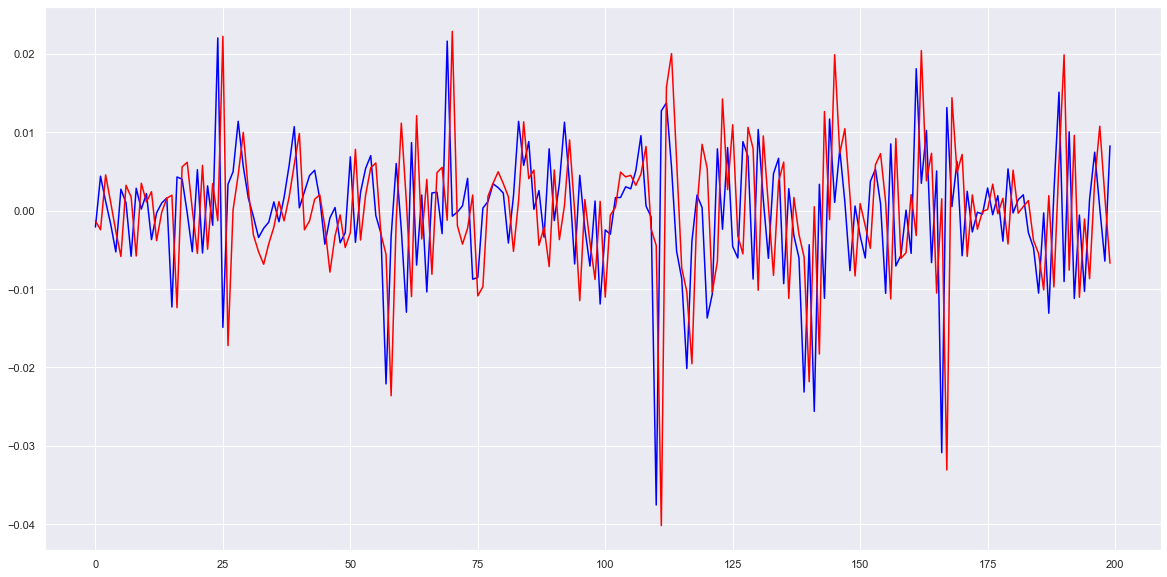

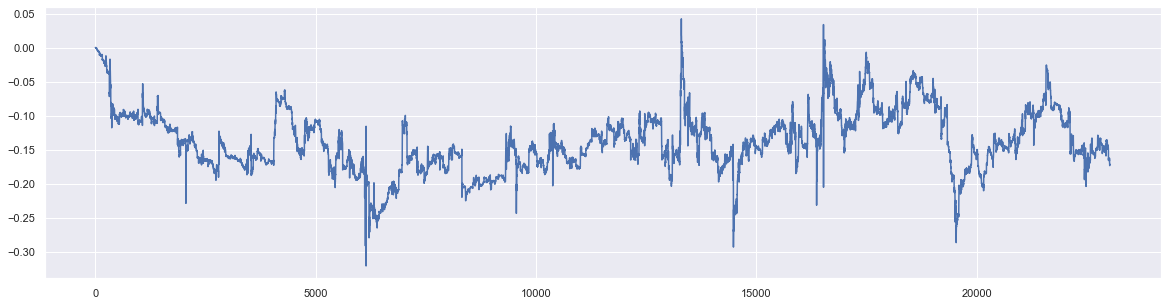

In [50]:
# Plot the combined portfolio
# print(preds[-100:])
plt.figure(figsize=(20,10))
plt.plot(df_test['next_log_diff'][-200:].values, color="blue", label="real")
plt.plot(series[-200:], color="red", label="preds")

# Plot the hedge ratio over time
plt.figure(figsize=(20,5))
plt.plot(mkf.x[0, 1:])

In [48]:
mse = mean_squared_error(y_true = df_test['next_log_diff'].values, 
                                      y_pred = series)
print(mse)

0.00023157362070536815


In [49]:
lag_mse = mean_squared_error(y_true = df_test['next_log_diff'].values, 
                                      y_pred = df_test['log_diff'].values)
print(lag_mse)

0.00021599723472073466


In [43]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [47]:
print(MAPE(df_test['next_log_diff'].values, np.array(series)))
print(type(np.array(series)), type(df_test['next_log_diff'].values))

inf
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [42]:
print(df_test['next_log_diff'].values, series)

[ 0.00080448 -0.01149147 -0.00547183 ...  0.0003104  -0.00644052
  0.00826959] [0.004099468106763204, 0.0004317536281637671, -0.011933404589540801, -0.0034487998183991364, 0.003104858085051536, 0.017403220357712912, -0.005995048177244481, -0.008416528061710475, 0.0014706806051563216, -0.018481456718023023, -0.004060375861714957, -0.012533404992739998, 0.025984607583313418, -0.000271198860437511, 0.0008433901262761435, 0.01159096487810745, -0.012125946915196249, 0.02721230184467267, 0.006334424557661981, -0.0130405703759114, 0.01269151484522539, -0.019791781658605383, -0.010602339557539921, 0.0013107118858727614, 0.008413144148532704, -0.03447712460260985, -0.002927982938648311, 0.01213895245839482, 0.011370141747308375, 0.02502756150536863, -0.008827507623519725, -0.00821630275002814, -0.011411309114742025, 0.025192024542895593, -0.011510067241214315, 0.031095750279787605, 0.002256625757176039, -0.01747786757687883, 0.008038421417695075, -0.01313012301166831, -0.00024661147413584505, -

In [63]:
def get_sarima_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_pred"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_pred"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [64]:
mape = {}
for coin in tracked_coins:
    mape_coin = get_sarima_mape(df, coin)
    mape[coin] = mape_coin

In [65]:
import statistics
sarima_mape = [x[-1] for x in mape.items()]
average_mape = statistics.fmean(sarima_mape)
print(average_mape)

0.0459284966997354


In [66]:
for coin in tracked_coins:

    df[coin + "_close_log_diff"] = np.log(df[coin]).diff(1)

    df[coin + "_20_SMA"] = df[coin + "_close_log_diff"].shift(1).rolling(window = 500, min_periods = 1).mean()
    df[coin + "_SMA_preds_exp"] = np.exp(df[coin + "_20_SMA"].values)
    df[coin + "_SMA_preds"] = df[coin + "_SMA_preds_exp"] * df[coin + "_1"]

In [67]:
def get_SMA_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_SMA_preds"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_SMA_preds"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [68]:
SMA_mape = {}
for coin in tracked_coins:
    SMA_mape_coin = get_SMA_mape(df, coin)
    SMA_mape[coin] = SMA_mape_coin
SMA_mape = [x[-1] for x in SMA_mape.items()]
average_SMA_mape = statistics.fmean(SMA_mape)
print(average_SMA_mape)

0.01449524146038071


In [69]:
def get_lag_mape(df, coin):
    # coin_df = df
    coin_df = df.drop(df[df.index.hour != 0].index)
    coin_df.drop(coin_df[coin_df[coin + "_1"].isna() != 0].index, inplace=True)
    mape = mean_absolute_percentage_error(y_true = coin_df[coin], 
                                      y_pred = coin_df[coin + "_1"])
    # print('Mape for ', coin, ': ', mape)
    return mape

In [70]:
lag_mape = {}
for coin in tracked_coins:
    lag_mape_coin = get_lag_mape(df, coin)
    lag_mape[coin] = lag_mape_coin
lag_mape = [x[-1] for x in lag_mape.items()]
average_lag_mape = statistics.fmean(lag_mape)
print(average_lag_mape)

0.014436160032555745


In [71]:
from sklearn.metrics import accuracy_score

def calculate_signal_accuracy(price_lag, close_price, prediction):

    delta_real = close_price - price_lag
    delta_prediction = prediction - price_lag

    signal_real = np.where(delta_real > 0, 1, 0)
    signal_prediction = np.where(delta_prediction > 0, 1, 0)
    accuracy = accuracy_score(signal_real, signal_prediction)

    return accuracy

In [72]:
df.head()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,XEM_SMA_preds_exp,XEM_SMA_preds,KNC_close_log_diff,KNC_20_SMA,KNC_SMA_preds_exp,KNC_SMA_preds,LRC_close_log_diff,LRC_20_SMA,LRC_SMA_preds_exp,LRC_SMA_preds
Time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 01:00:00,30.62,NaN,10898.54,0.02711,NaN,0.05071,0.3239,2.093,0.002763,2.514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 02:00:00,31.10,NaN,10999.70,0.02751,NaN,0.04994,0.3155,2.197,0.002851,2.541,...,NaN,NaN,0.003571,NaN,NaN,NaN,0.007667,NaN,NaN,NaN
2019-07-01 03:00:00,31.28,NaN,11085.91,0.02704,NaN,0.05379,0.3311,2.134,0.002935,2.575,...,1.005813,0.092233,0.009460,0.003571,1.003577,0.253403,0.004536,0.007667,1.007697,0.055413
2019-07-01 04:00:00,31.25,NaN,11086.59,0.02757,NaN,0.04949,0.3305,2.125,0.002827,2.557,...,1.003285,0.092071,0.000784,0.006515,1.006537,0.256566,0.020427,0.006102,1.006120,0.055578
2019-07-01 05:00:00,31.16,NaN,11013.00,0.02739,NaN,0.04945,0.3247,2.120,0.002802,2.516,...,1.009740,0.094774,-0.007476,0.004605,1.004616,0.256277,-0.010878,0.010877,1.010936,0.056997


In [73]:
total_accuracy_lag = []
total_accuracy_SMA = []
total_accuracy_SARIMAX = []
df_accuracy = pd.DataFrame(columns=["accuracy_lag", "accuracy_SMA", "accuracy_SARIMAX","starting_on"], index=tracked_coins)

for coin in tracked_coins:

    coin_df = df.copy()

    coin_df.drop(coin_df[coin_df.index.hour != 0].index, inplace=True)
    coin_df.drop(coin_df[coin_df[coin + "_pred"].isna() != 0].index, inplace=True)

    accuracy_lag = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_1"])
    accuracy_SMA = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_SMA_preds"])
    accuracy_SARIMAX = calculate_signal_accuracy(coin_df[coin + "_1"], coin_df[coin], coin_df[coin + "_pred"])

    total_accuracy_lag.append(accuracy_lag)
    total_accuracy_SMA.append(accuracy_SMA)
    total_accuracy_SARIMAX.append(accuracy_SARIMAX)

    df_accuracy["accuracy_lag"][coin] = accuracy_lag
    df_accuracy["accuracy_SMA"][coin] = accuracy_SMA
    df_accuracy["accuracy_SARIMAX"][coin] = accuracy_SARIMAX
    df_accuracy["starting_on"][coin] = coin_df.index[0]

df_accuracy.to_csv('accuracy_scores.csv', sep=";", encoding="UTF-8")

In [74]:
print('Toal accuracy based on lag prediction: ', 100*statistics.fmean(total_accuracy_lag),'%')
print('Signal accuracy based on moving average prediction: ', 100*statistics.fmean(total_accuracy_SMA),'%')
print('Signal accuracy based on SARIMAX prediction: ', 100*statistics.fmean(total_accuracy_SARIMAX),'%')

Toal accuracy based on lag prediction:  52.82260199426096 %
Signal accuracy based on moving average prediction:  49.21690422948008 %
Signal accuracy based on SARIMAX prediction:  51.2551351623337 %
